In [27]:
from ptracking.database.database import cursor
import matplotlib.pyplot as plt
import datetime

In [28]:
with cursor() as cur:
    cur.execute("select distinct rejected_reason, count(*) from petition where state = 'rejected' group by rejected_reason")
    res = cur.fetchall()
    cur.execute("Select 'not-rejected', count(*) from petition where state <> 'rejected'")
    accepted, num_accepted = cur.fetchone()


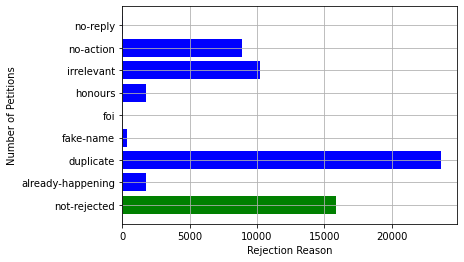

In [29]:
reasons = [accepted]
counts = [num_accepted]
for reason, count in res:
    reasons.append(reason)
    counts.append(count)

# plt.xticks(rotation=90)
plt.ylabel("Number of Petitions")
plt.xlabel("Rejection Reason")
plt.grid()
# plt.invert_yaxis()  # labels read top-to-bottom
plt.barh(width=counts, y=reasons, color=["green"] + ['blue'] * 8)
plt.savefig("plots/reason_counts.pdf", bbox_inches='tight')

In [30]:
reasons.remove("not-rejected")
signature_counts_by_reason = {}
for reason in reasons:
    with cursor() as cur:
        cur.execute("Select signatures from petition where state = 'rejected' and rejected_reason = %s", (reason, ))
        rejected_signatures = cur.fetchall()

    rejected_signatures = [t for (t,) in rejected_signatures]
    signature_counts_by_reason[reason] = rejected_signatures

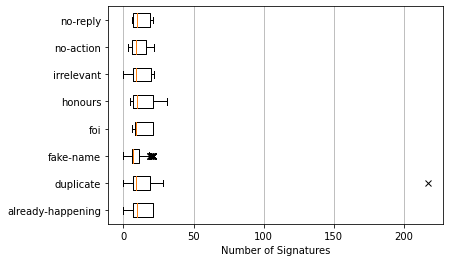

In [31]:
fig, ax = plt.subplots()
ax.xaxis.grid()
ax.boxplot(signature_counts_by_reason.values(), vert=False, sym="x")
ax.set_xlabel("Number of Signatures")
ax.set_yticklabels(signature_counts_by_reason.keys())
fig.savefig("./plots/number_of_signatures.pdf", bbox_inches='tight')

(-0.02988660997977248, 1.0813604478345438e-10)


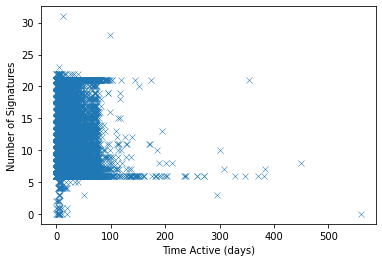

In [32]:
from scipy.stats import pearsonr

with cursor() as cur:
    cur.execute("select rejected_at - created_at as time, signatures from petition where state = 'rejected' and signatures < 200 order by time asc")
    time_before_rejection = cur.fetchall()

times = []
signatures = []
for time, count in time_before_rejection:
    times.append(time.days)
    signatures.append(count)

print(pearsonr(times, signatures))
plt.ylabel("Number of Signatures")
plt.xlabel("Time Active (days)")
plt.scatter(times, signatures, marker="x", linewidths=0.5)
plt.savefig("plots/time_actve_vs_signatures.pdf", bbox_inches='tight')

In [33]:
import pandas as pd

with cursor() as cur:
    cur.execute("""
        select 
            rej.petition_id,
            rej.signatures,
            rej.rejected_at - rej.created_at as time,
            rej.rejected_reason,
            count(created.petition_id) - 1 from (select 
                petition_id,
                rejected_at,
                rejected_reason,
                created_at,
                signatures 
            from petition where state = 'rejected' and signatures < 200
        )
        as rej join petition as created on (date_trunc('day', rej.created_at) = date_trunc('day', created.created_at)) group by rej.petition_id, rej.signatures, time, rej.rejected_reason""")
    created_on_same_day = cur.fetchall()


print(created_on_same_day[:10])

[(200010, 6, datetime.timedelta(seconds=2617, microseconds=896000), 'no-action', 64), (200012, 6, datetime.timedelta(seconds=8380, microseconds=298000), 'no-action', 64), (200018, 7, datetime.timedelta(seconds=20225, microseconds=403000), 'no-action', 64), (200019, 21, datetime.timedelta(seconds=3143, microseconds=819000), 'no-action', 64), (200022, 12, datetime.timedelta(seconds=4591, microseconds=643000), 'no-action', 64), (200030, 21, datetime.timedelta(seconds=13959, microseconds=887000), 'no-action', 64), (200039, 6, datetime.timedelta(days=1, seconds=15512, microseconds=64000), 'no-action', 64), (200040, 6, datetime.timedelta(days=5, seconds=81337, microseconds=163000), 'duplicate', 64), (200048, 17, datetime.timedelta(days=3, seconds=13378, microseconds=376000), 'no-action', 64), (200049, 9, datetime.timedelta(days=19, seconds=77631, microseconds=784000), 'duplicate', 64)]


   petition_id  signatures  time_active     reason  created_on_same_day
0       200010           6     2617.896  no-action                   64
1       200012           6     8380.298  no-action                   64
2       200018           7    20225.403  no-action                   64
3       200019          21     3143.819  no-action                   64
4       200022          12     4591.643  no-action                   64
5       200030          21    13959.887  no-action                   64
6       200039           6   101912.064  no-action                   64
7       200040           6   513337.163  duplicate                   64
8       200048          17   272578.376  no-action                   64
9       200049           9  1719231.784  duplicate                   64


(array([1.1944e+04, 1.8122e+04, 4.0110e+03, 2.5710e+03, 2.1600e+03,
        1.9350e+03, 1.3680e+03, 8.9600e+02, 9.8800e+02, 4.8000e+02,
        3.2100e+02, 3.8800e+02, 7.3100e+02, 4.3800e+02, 6.8000e+01,
        3.7000e+01, 3.0000e+01, 2.2000e+01, 1.8000e+01, 7.0000e+00,
        1.6000e+01, 7.0000e+00, 3.0000e+00, 7.0000e+00, 1.2000e+01,
        3.0000e+00, 7.0000e+00, 3.0000e+00, 4.0000e+00, 0.0000e+00,
        1.0000e+00, 3.0000e+00, 2.0000e+00, 4.0000e+00, 1.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

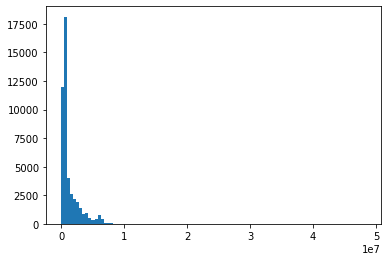

In [34]:
df = pd.DataFrame(created_on_same_day, columns=["petition_id", "signatures", "time_active", "reason", "created_on_same_day"])
df["time_active"] = df["time_active"].dt.total_seconds()
print(df.head(10))
df.to_csv("petitions.csv", index=False)

plt.hist(df['time_active'], bins =100)

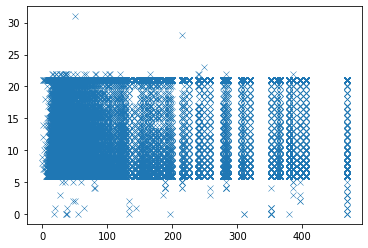

In [35]:
plt.scatter(df["created_on_same_day"], df["signatures"], marker="x", linewidths=0.5)

(array([  11.,   73.,  457., 1161., 2688., 3836., 3468., 3875., 3657.,
        2103., 2090., 1549., 1326., 1652., 1099.,  889., 1071.,  835.,
         675.,  551.,  328.,  669.,  499.,  188.,  300.,  712.,  332.,
         415.,  334.,    0.,  238.,    0.,  255.,  561.,  281.,  439.,
           0.,  298.,  322.,  156.,  167.,  183.,  353.,    0.,    0.,
         197.,  194.,    0.,  200.,    0.,    0.,  431.,    0.,  221.,
           0.,  240.,    0.,    0.,    0.,  484.,  513.,    0.,    0.,
           0.,    0.,  289.,  291.,    0.,  269.,    0.,    0.,    0.,
           0.,    0.,    0.,  324.,    0.,  660.,    0.,    0.,  700.,
           0.,  355.,    0.,  367.,    0.,  360.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         441.]),
 array([  0.  ,   4.68,   9.36,  14.04,  18.72,  23.4 ,  28.08,  32.76,
         37.44,  42.12,  46.8 ,  51.48,  56.16,  60.84,  65.52,  70.2 ,
         74.88,  79.56,  84.24,  88.92,  93.6 ,  98.28, 10

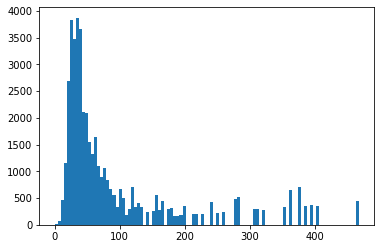

In [36]:
plt.hist([t[4] for t in created_on_same_day], bins=100)

Text(0.5, 3.200000000000003, 'Number of petitions created on the same day')

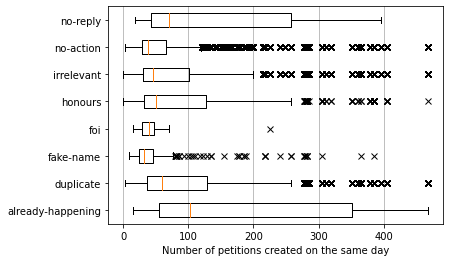

In [37]:
groups = {}
for group, series in df[["reason", "created_on_same_day"]].groupby(["reason"]):
    groups[group] = series['created_on_same_day']

fig, ax = plt.subplots()
ax.xaxis.grid()
ax.boxplot(groups.values(), vert=False, sym="x")
ax.set_yticklabels(groups.keys())
fig.savefig("./plots/number_of_created.pdf", bbox_inches='tight')
plt.xlabel("Number of petitions created on the same day")

Text(0.5, 3.200000000000003, 'Time Active before rejection (hours)')

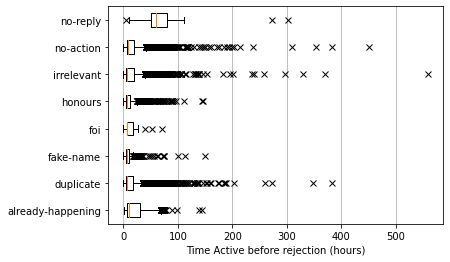

In [38]:
groups = {}
for group, series in df[["reason", "time_active"]].groupby(["reason"]):
    groups[group] = series['time_active'] / 86400

fig, ax = plt.subplots()
ax.xaxis.grid()
ax.boxplot(groups.values(), vert=False, sym="x")
ax.set_yticklabels(groups.keys())
fig.savefig("./plots/time_active.pdf", bbox_inches='tight')
plt.xlabel("Time Active before rejection (hours)")

In [39]:
from scipy.stats import zscore

df_stand = df.copy()
df_stand[["signatures", "time_active", "created_on_same_day"]] = df[["signatures", "time_active", "created_on_same_day"]].apply(zscore)
df_stand.to_csv("./petitoncs_stand.csv", index=False)

In [40]:
with cursor() as cur:
    cur.execute("SELECT a.petition_id, a.signatures, a.state, count(s.petition_id) - 1 from petition a join petition s on (date_trunc('day', a.created_at) = date_trunc('day', s.created_at)) where a.state <> 'open' group by a.petition_id, a.signatures, a.state")
    res = cur.fetchall()

df_states = pd.DataFrame(res, columns=["petition_id", "signatures", "state", "created_same_day"])
print(df_states.head())

   petition_id  signatures   state  created_same_day
0          347      148373  closed                 1
1          356       59346  closed                 1
2          885      149470  closed                 0
3         1535      113490  closed                 1
4         2199      156218  closed                 1


In [41]:
print(df_states.groupby(["state"]).count())

          petition_id  signatures  created_same_day
state                                              
closed          14121       14121             14121
rejected        46633       46633             46633


In [42]:
df_states.to_csv("petition_state.csv", index=False)
df_states[["signatures", "created_same_day"]] = df_states[["signatures", "created_same_day"]].apply(zscore)
df_states.to_csv("petition_state_stand.csv", index=False)

In [43]:
print(df.sort_values("created_on_same_day", ascending=False))

       petition_id  signatures  time_active             reason  \
21920       307387          21   543330.022  already-happening   
21975       307494           4   534319.664  already-happening   
21985       307515           6   532382.083          duplicate   
21984       307513          21   840015.900          duplicate   
21983       307508          21   871910.165  already-happening   
...            ...         ...          ...                ...   
1976        208302           7   842013.828          duplicate   
1977        208306          12   747932.842         irrelevant   
19051       278910          14   340902.836            honours   
19052       278967           9   249197.955            honours   
19053       279047           8   166076.866         irrelevant   

       created_on_same_day  
21920                  468  
21975                  468  
21985                  468  
21984                  468  
21983                  468  
...                    ...  
1976

reason
already-happening     1732
duplicate            23648
fake-name              348
foi                     18
honours               1734
irrelevant           10214
no-action             8888
no-reply                50
Name: reason, dtype: int64
reason
already-happening    102.0
duplicate             60.0
fake-name             32.0
foi                   40.0
honours               50.0
irrelevant            46.0
no-action             38.0
no-reply              70.5
Name: created_on_same_day, dtype: float64
(-0.03865134452875256, 0.9276008744916983)


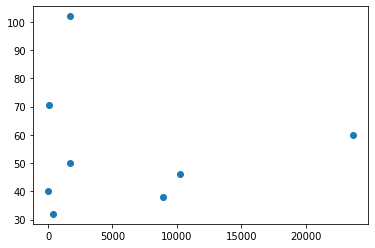

In [44]:
rejected_counts = df.groupby("reason")["reason"].count()
avg_create = df.groupby("reason")["created_on_same_day"].median()
print(rejected_counts)
print(avg_create)

print(pearsonr(rejected_counts, avg_create))
plt.scatter(rejected_counts, avg_create)

In [45]:
errors_df = pd.read_csv("./errors.csv")
print(errors_df)

       signatures  time_active  prediction margin predicted reason     reason  \
0       -0.987378    -0.827684          -0.304490        duplicate  no-action   
1       -0.987378    -0.824084          -0.304349        duplicate  no-action   
2       -0.819707    -0.816684          -0.307776        duplicate  no-action   
3        1.527674    -0.827355          -0.353385        duplicate  no-action   
4        0.018643    -0.826451          -0.325741        duplicate  no-action   
...           ...          ...                ...              ...        ...   
46627   -0.316697    -0.581926           0.232820        duplicate  duplicate   
46628   -0.987378    -0.581920          -0.215364        duplicate  no-action   
46629   -0.484367    -0.610768          -0.228241        duplicate  no-action   
46630    1.192334    -0.627937           0.256683        duplicate  duplicate   
46631    1.527674    -0.628706           0.256363        duplicate  duplicate   

       created_on_same_day 

[[2.3000e+01 8.8620e+03 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 3.0000e+00]
 [2.8000e+01 2.3618e+04 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 2.0000e+00]
 [3.0000e+00 1.7310e+03 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [2.1000e+01 1.0190e+04 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  1.0000e+00 2.0000e+00]
 [0.0000e+00 3.4700e+02 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  1.0000e+00 0.0000e+00]
 [0.0000e+00 1.8000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [1.0000e+00 1.7310e+03 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [2.0000e+00 4.8000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]]


<AxesSubplot:>

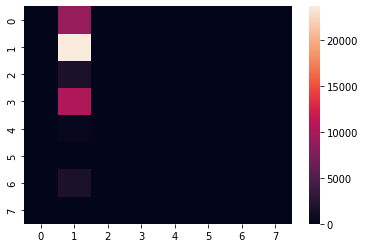

In [46]:
import seaborn as sns;
import numpy as np
from collections import defaultdict

counts = np.ndarray(shape=(8, 8))
hm = errors_df[["reason", "predicted reason"]]
for i, reason_a in enumerate(hm.reason.unique()):
    for j, reason_b in enumerate(hm.reason.unique()):
        correct = len(hm[(hm["reason"] == reason_a) & (hm["predicted reason"] == reason_b)])
        counts[i, j] = correct

print(counts)
sns.heatmap(counts)

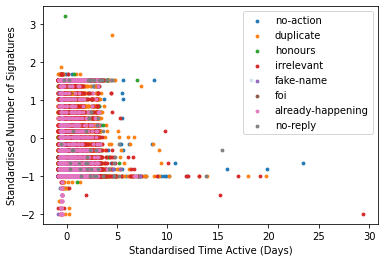

In [47]:
clusters = pd.read_csv("./clusters.csv")


reasons_colours = {
    "no-reply": 0,
    "honours": 1,
    "duplicate": 2,
    "foi": 3, 
    "no-action": 4, 
    "irrelevant": 5, 
    "already-happening": 6, 
    "fake-name": 7, 
}

fig, ax = plt.subplots()
ax.set_xlabel("Standardised Time Active (Days)")
ax.set_ylabel("Standardised Number of Signatures")
for g in clusters["reason"].unique():
    vals = clusters[clusters.reason == g]
    ax.scatter(vals["time_active"], vals["signatures"], label=g, s=8)
ax.legend()
plt.savefig("plots/signatures_vs_time_cluster.pdf", bbox_inches='tight')

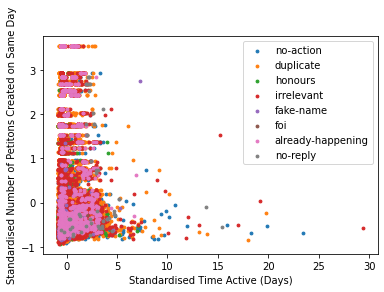

In [48]:
fig, ax = plt.subplots()
ax.set_xlabel("Standardised Time Active (Days)")
ax.set_ylabel("Standardised Number of Petitons Created on Same Day")
for g in clusters["reason"].unique():
    vals = clusters[clusters.reason == g]
    ax.scatter(vals["time_active"], vals["created_on_same_day"], label=g, s=8)
ax.legend()
plt.savefig("plots/created_vs_time_cluster.pdf", bbox_inches='tight')